# **Analysis of an Ex-Dividend Day Trading Strategy**

This notebook analyzes the profitability of an ex-dividend day trading strategy using historical stock data from the Center for Research in Security Prices (CRSP). The analysis focuses on the price behavior of stocks around their ex-dividend dates and evaluates strategy performance based on various return calculations and considerations of transaction costs.

---

# **1. Data Preparation**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Projects/Data/'

In [ ]:
# 0) Load
div = pd.read_csv(path + '/' + 'CRSP_Dividends.csv', parse_dates=['date'])
pre_n = len(div)

# 1) Basic filters per assignment
div['PRC'] = div['PRC'].abs()                         # CRSP convention
div = div[div['DIVAMT'] >= 0.01].copy()               # drop tiny dividends
div['mkt_cap'] = div['PRC'] * div['SHROUT'] * 1000    # SHROUT in thousands
div = div[div['mkt_cap'] >= 50_000_000].copy()        # >= $50M
if 'SHRCD' in div.columns:
    div = div[div['SHRCD'].isin([10, 11])].copy()     # common shares only

# 2) Tradability flag (keep VOL=0 here; filter later in Q2/Q4/Q5)
div['tradable'] = div['VOL'] > 0

# 3) Resolve same-day duplicates: sum DIVAMT; keep one row per PERMNO–date
dedup = (
    div.sort_values(['PERMNO', 'date', 'VOL'], ascending=[True, True, False])
       .groupby(['PERMNO', 'date'], as_index=False)
       .agg({
           'DIVAMT':'sum',
           'PRC':'first', 'RET':'first', 'RETX':'first',
           'VOL':'max',   # if any trade happened that day, stays tradable
           'SHROUT':'first', 'vwretd':'first', 'OPENPRC':'first',
           'BID':'first', 'ASK':'first',
           'SHRCD':'first', 'PERMCO':'first', 'DISTCD':'first',
           'mkt_cap':'first'
       })
)

# 4) Final tidy fields
div = dedup.sort_values(['PERMNO','date']).reset_index(drop=True)
div['Year']    = div['date'].dt.year                   # for beta merge in Q3
div['mkt_cap'] = div['PRC'] * div['SHROUT'] * 1000     # recompute after agg
div['tradable'] = div['VOL'] > 0                       # refresh flag

# 5) Quick summary
post_n = len(div)
print(f"Rows before: {pre_n:,} | after: {post_n:,} | dropped: {pre_n-post_n:,} ({(pre_n-post_n)/pre_n:,.1%})")
print(f"Tradable rows (VOL>0): {div['tradable'].sum():,} / {post_n:,} ({div['tradable'].mean():.1%})")
print("Date range:", div['date'].min().date(), "→", div['date'].max().date(),
      "| Unique event days:", div['date'].nunique())
display(div.select_dtypes('number').describe().T)

Rows before: 458,220 | after: 336,274 | dropped: 121,946 (26.6%)
Tradable rows (VOL>0): 317,471 / 336,274 (94.4%)
Date range: 1962-01-02 → 2023-06-30 | Unique event days: 15212


,count,mean,std,min,25%,50%,75%,max
PERMNO,336274.0,4.765941e+04,2.642135e+04,1.000100e+04,2.324500e+04,4.531300e+04,7.529400e+04,9.342900e+04
DIVAMT,336274.0,2.570343e-01,5.070397e-01,1.000000e-02,1.000000e-01,2.000000e-01,3.250000e-01,8.500000e+01
PRC,336274.0,3.683185e+01,5.358830e+01,1.010000e+00,1.860000e+01,2.789000e+01,4.223000e+01,4.280040e+03
RET,336274.0,2.662647e-03,2.245545e-02,-7.298640e-01,-7.845000e-03,2.445000e-03,1.228900e-02,6.968220e-01
RETX,336274.0,-5.526400e-03,2.502956e-02,-8.785530e-01,-1.644700e-02,-5.076000e-03,4.902000e-03,6.915890e-01
VOL,323968.0,6.632036e+05,3.731994e+06,0.000000e+00,5.200000e+03,3.334200e+04,2.619468e+05,4.634910e+08
SHROUT,336274.0,1.008668e+05,4.254894e+05,1.910000e+02,6.898000e+03,1.811100e+04,5.696200e+04,1.700180e+07
vwretd,336274.0,4.265552e-04,1.012420e-02,-1.713460e-01,-3.988000e-03,8.060000e-04,5.280000e-03,1.149210e-01
OPENPRC,180158.0,4.094056e+01,6.952399e+01,5.000000e-01,1.820000e+01,2.875000e+01,4.606250e+01,4.411960e+03
BID,196004.0,3.942634e+01,6.668964e+01,1.000000e+00,1.775000e+01,2.768750e+01,4.425000e+01,4.261960e+03


**Reasoning**:
The data has been successfully loaded and initially cleaned. The next step is to load and prepare the auxiliary data (IRX and Fama-French factors) which are used in subsequent analyses. I will load them, rename columns for consistency, and perform necessary data type conversions and filtering.



In [ ]:
# Load and prepare IRX data
irx = pd.read_csv(path + '/' + '^IRX.csv', parse_dates=['Date'])
irx = irx.rename(columns={'Date':'date'}).set_index('date')

# Load and prepare Fama-French daily data
ff = pd.read_csv(path + '/' + 'FamaFrenchDaily.csv')
ff = ff.rename(columns={'Date':'date'})
ff['date'] = pd.to_datetime(ff['date'], format='%Y%m%d', errors='coerce')
ff[['Mkt-RF','RF']] = ff[['Mkt-RF','RF']].apply(pd.to_numeric, errors='coerce') / 100.0
ff = ff[['date','Mkt-RF','RF']].dropna(subset=['date']).sort_values('date')

print("IRX data loaded and prepared:")
print("Shape:", irx.shape)
print("Date range:", irx.index.min().date(), "→", irx.index.max().date())
display(irx.head())

print("\nFama-French data loaded and prepared:")
print("Shape:", ff.shape)
print("Date range:", ff['date'].min().date(), "→", ff['date'].max().date())
display(ff.head())

IRX data loaded and prepared:
Shape: (19787, 6)
Date range: 1960-01-04 → 2023-09-10


,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
1960-01-04,4.52,4.52,4.52,4.52,4.52,0.0
1960-01-05,4.55,4.55,4.55,4.55,4.55,0.0
1960-01-06,4.68,4.68,4.68,4.68,4.68,0.0
1960-01-07,4.63,4.63,4.63,4.63,4.63,0.0
1960-01-08,4.59,4.59,4.59,4.59,4.59,0.0



Fama-French data loaded and prepared:
Shape: (26023, 3)
Date range: 1926-07-01 → 2025-06-30


,date,Mkt-RF,RF
0,1926-07-01,0.0009,0.00009
1,1926-07-02,0.0045,0.00009
2,1926-07-06,0.0017,0.00009
3,1926-07-07,0.0009,0.00009
4,1926-07-08,0.0022,0.00009


#**2. Ex-Dividend Price Drop Analysis**

In [ ]:
# Calculate price at t-1 using RETX
div['Ptm1'] = div['PRC'] / (1.0 + div['RETX'])

# Calculate the price drop as a fraction of the dividend
div['drop_over_div'] = (div['Ptm1'] - div['PRC']) / div['DIVAMT']

# Calculate dividend yield
div['D_over_P'] = div['DIVAMT'] / div['Ptm1']

# Summarize the drop_over_div ratio, handling potential inf/NaN values
drop_over_div_summary = div['drop_over_div'].replace([np.inf, -np.inf], np.nan).dropna().describe()

print("Summary of (Ptm1 - Pt) / DIVAMT (drop_over_div):")
display(drop_over_div_summary)

# Calculate and print robust range for drop_over_div
r = div['drop_over_div'].replace([np.inf, -np.inf], np.nan).dropna()
q01, q99 = r.quantile([0.01, 0.99])
print(f"drop_over_div robust 1–99% range: [{q01:.3f}, {q99:.3f}]")

Summary of (Ptm1 - Pt) / DIVAMT (drop_over_div):


,drop_over_div
count,336274.000000
mean,0.573576
std,10.248553
min,-906.248481
25%,-0.823323
50%,0.666655
75%,2.099887
max,1071.995035


drop_over_div robust 1–99% range: [-25.000, 25.000]


# **3. Close-to-Close Returns Analysis**

In [ ]:
# Helper function to calculate annualized statistics
def ann_stats(r, rf=None, td=252):
    r = pd.Series(r).dropna()
    mu, sd = r.mean(), r.std(ddof=1)
    ann_ret = (1 + mu)**td - 1
    ann_sd  = sd * np.sqrt(td)
    if rf is not None:
        rf = pd.Series(rf).reindex(r.index)
        x  = (r - rf).dropna()
        sharpe = np.sqrt(td) * (x.mean()/x.std(ddof=1)) if x.std(ddof=1) > 0 else np.nan
    else:
        sharpe = np.nan
    return pd.Series({'ann_return': ann_ret, 'ann_stdev': ann_sd, 'sharpe': sharpe})

# Filter for tradable events
q2 = div[div['tradable']].copy()

# Close-to-close event return (includes the dividend): use RET
q2['r_event_c2c'] = q2['RET']

# Daily equal-weight portfolio across all tradable ex-div events
daily_c2c_ew = (q2.groupby('date', as_index=False)
           .agg(r_eq=('r_event_c2c','mean'),
                n_events=('r_event_c2c','size')))

# Merge FF daily RF (already in decimals)
daily_c2c_ew = daily_c2c_ew.merge(ff[['date','RF']], on='date', how='left').set_index('date')

# Calculate and display annualized statistics for the equal-weight portfolio
stats_c2c_ew = ann_stats(daily_c2c_ew['r_eq'], daily_c2c_ew['RF'])
print("\nClose-to-close Equal-Weight Portfolio Stats:")
display(stats_c2c_ew)


Close-to-close Equal-Weight Portfolio Stats:


,0
ann_return,0.765132
ann_stdev,0.193050
sharpe,2.725391


In [ ]:
# Daily value-weight portfolio across all tradable ex-div events
daily_c2c_vw = (q2.groupby('date')
              .apply(lambda g: np.average(g['r_event_c2c'], weights=g['mkt_cap']))
           ).to_frame('r_vw').reset_index()

# Merge FF daily RF (already in decimals)
daily_c2c_vw = daily_c2c_vw.merge(ff[['date','RF']], on='date', how='left').set_index('date')

# Calculate and display annualized statistics for the value-weight portfolio
stats_c2c_vw = ann_stats(daily_c2c_vw['r_vw'], daily_c2c_vw['RF'])
print("\nClose-to-close Value-Weight Portfolio Stats:")
display(stats_c2c_vw)


Close-to-close Value-Weight Portfolio Stats:


/tmp/ipython-input-3635601081.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g['r_event_c2c'], weights=g['mkt_cap']))


,0
ann_return,0.446125
ann_stdev,0.213033
sharpe,1.531978


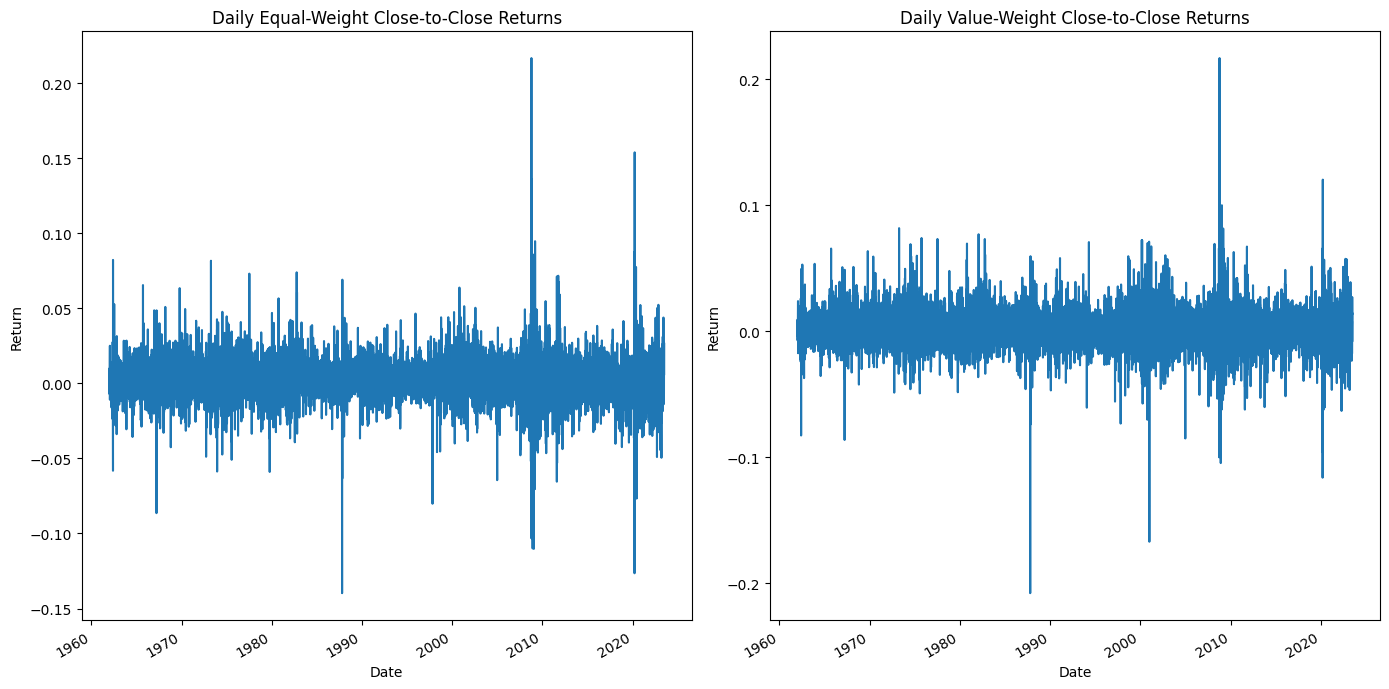

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
daily_c2c_ew['r_eq'].plot()
plt.title('Daily Equal-Weight Close-to-Close Returns')
plt.xlabel('Date')
plt.ylabel('Return')

plt.subplot(1, 2, 2)
daily_c2c_vw['r_vw'].plot()
plt.title('Daily Value-Weight Close-to-Close Returns')
plt.xlabel('Date')
plt.ylabel('Return')

plt.tight_layout()
plt.show()

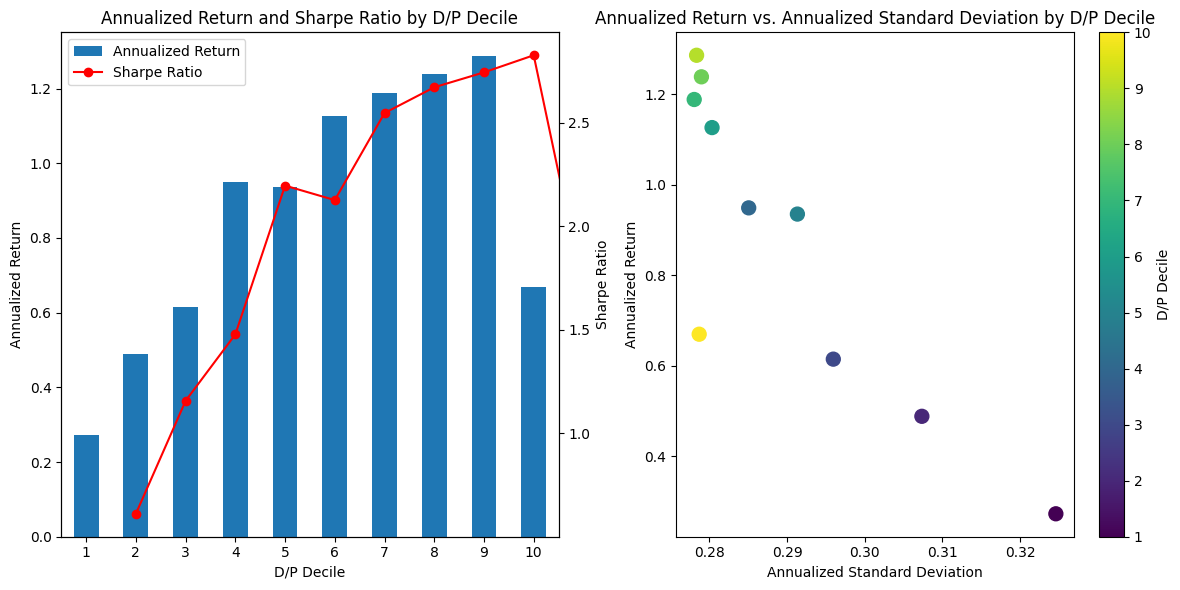

In [ ]:
plt.figure(figsize=(12, 6))

# Plot Annualized Return and Sharpe Ratio by Decile
ax1 = plt.subplot(1, 2, 1)
decile_table.plot(x='dp_decile', y='ann_return', kind='bar', ax=ax1, legend=False)
plt.ylabel('Annualized Return')
plt.title('Annualized Return and Sharpe Ratio by D/P Decile')
plt.xlabel('D/P Decile')
plt.xticks(rotation=0)

ax2 = ax1.twinx()
decile_table.plot(x='dp_decile', y='sharpe', kind='line', marker='o', color='red', ax=ax2, legend=False)
plt.ylabel('Sharpe Ratio')

# Add combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, ['Annualized Return', 'Sharpe Ratio'], loc='upper left')

# Scatter plot of Annualized Return vs Annualized Standard Deviation
ax3 = plt.subplot(1, 2, 2)
scatter = ax3.scatter(decile_table['ann_stdev'], decile_table['ann_return'], c=decile_table['dp_decile'], cmap='viridis', s=100)
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Return')
plt.title('Annualized Return vs. Annualized Standard Deviation by D/P Decile')
plt.colorbar(scatter, label='D/P Decile')

plt.tight_layout()
plt.show()

# **4. CAPM Analysis**

In [ ]:
# Load and prepare yearly betas data
betas = pd.read_csv(path + '/' + 'Yearly Betas.csv')

# Standardize the betas file
betas = betas.rename(columns={'DATE':'beta_date', 'b_mkt':'beta'})
betas['beta_date']  = pd.to_datetime(betas['beta_date'], errors='coerce')
betas['beta_year']  = betas['beta_date'].dt.year
betas['beta']       = pd.to_numeric(betas['beta'], errors='coerce')

# Keep one beta per PERMNO–year (latest date within the year)
betas = (betas.sort_values(['PERMNO','beta_date'])
               .drop_duplicates(['PERMNO','beta_year'], keep='last')
               [['PERMNO','beta_year','beta']])

print("Betas data loaded and prepared:")
print("Shape:", betas.shape)
print("Years:", betas['beta_year'].min(), "→", betas['beta_year'].max())
display(betas.head())

Betas data loaded and prepared:
Shape: (289852, 3)
Years: 1962 → 2022


,PERMNO,beta_year,beta
0,10001,1988,0.0730
1,10001,1989,0.0799
2,10001,1990,0.0986
3,10001,1991,-0.0132
4,10001,1992,-0.0178


In [ ]:
# Attach the lagged beta (event in Y uses beta from Y-1)
q3 = div[div['tradable']].copy()
q3['beta_year'] = q3['date'].dt.year - 1
q3 = q3.merge(betas[['PERMNO','beta_year','beta']], on=['PERMNO','beta_year'], how='left')

# Attach FF factors (Mkt-RF, RF) for the event date
q3 = q3.merge(ff[['date','Mkt-RF','RF']], on='date', how='left')

# CAPM expected return and abnormal return
q3['E_CAPM'] = q3['RF'] + q3['beta'] * q3['Mkt-RF']    # E[R] = RF + beta*(Mkt-RF)
q3['AR']     = q3['RET'] - q3['E_CAPM']                # event abnormal return (c→c window)

# Quick summaries
print("AR coverage:", q3['AR'].notna().mean(), "of rows have a beta & RF/Mkt-RF")
display(q3[['AR','RET','E_CAPM','beta']].describe())

# Daily equal-weight abnormal return (cluster by date for inference)
daily_AR = q3.groupby('date', as_index=True)['AR'].mean()

# Annualized mean AR and Sharpe of AR
ann_AR   = (1 + daily_AR.mean())**252 - 1
ann_sd   = daily_AR.std(ddof=1) * np.sqrt(252)
sharpeAR = np.sqrt(252) * (daily_AR.mean() / daily_AR.std(ddof=1)) if daily_AR.std(ddof=1)>0 else np.nan

# Simple t-stat on the daily series (date-level, avoids overweighting busy days)
t_stat = daily_AR.mean() / (daily_AR.std(ddof=1) / np.sqrt(daily_AR.count()))

print(f"Annualized mean AR: {ann_AR:.3f} | Annualized stdev: {ann_sd:.3f} | Sharpe(AR): {sharpeAR:.2f} | t = {t_stat:.2f}")

AR coverage: 0.9193280646106259 of rows have a beta & RF/Mkt-RF


,AR,RET,E_CAPM,beta
count,291860.000000,317471.000000,291860.000000,291860.000000
mean,0.001906,0.002417,0.000467,0.969255
std,0.020819,0.022652,0.011307,0.516074
min,-0.735668,-0.729864,-0.270852,-1.659100
25%,-0.008179,-0.008250,-0.003150,0.613300
50%,0.001395,0.002123,0.000531,0.940950
75%,0.011071,0.012220,0.004542,1.274300
max,0.697427,0.696822,0.296150,6.383400


Annualized mean AR: 0.561 | Annualized stdev: 0.138 | Sharpe(AR): 3.24 | t = 24.88


In [ ]:
# --- VW daily AR series (weights = mkt_cap) ---
daily_AR_vw = (
    q3.assign(wx=lambda d: d['AR']*d['mkt_cap'])
      .groupby('date')
      .agg(sum_wx=('wx','sum'), sum_w=('mkt_cap','sum'))
      .eval('AR_vw = sum_wx / sum_w')['AR_vw']
)

# t-stat on the date-level VW series
mu_vw = daily_AR_vw.mean()
sd_vw = daily_AR_vw.std(ddof=1)
n_vw  = daily_AR_vw.count()
t_vw  = mu_vw / (sd_vw / np.sqrt(n_vw))

ann_AR_vw = (1 + mu_vw)**252 - 1
ann_sd_vw = sd_vw * np.sqrt(252)
sh_vw     = np.sqrt(252) * (mu_vw / sd_vw)

print(f"VW — Annualized mean AR: {ann_AR_vw:.3f} | stdev: {ann_sd_vw:.3f} | Sharpe: {sh_vw:.2f} | t: {t_vw:.2f}  (date-level)")

VW — Annualized mean AR: 0.262 | stdev: 0.144 | Sharpe: 1.61 | t: 12.53  (date-level)


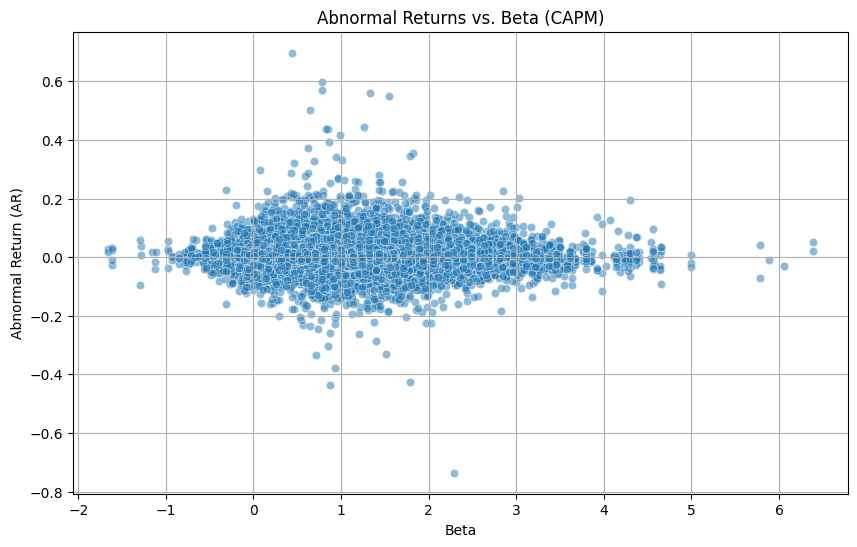

In [ ]:
# Scatter plot of Abnormal Returns vs Beta
plt.figure(figsize=(10, 6))
sns.scatterplot(data=q3, x='beta', y='AR', alpha=0.5)
plt.title('Abnormal Returns vs. Beta (CAPM)')
plt.xlabel('Beta')
plt.ylabel('Abnormal Return (AR)')
plt.grid(True)
plt.show()

*   **Concentration around zero AR:** A large cluster of points near the horizontal axis (AR = 0) suggests that for many events, the CAPM effectively explains the observed return.
*   **Spread of AR values:** However, there is a significant spread of abnormal returns, particularly for stocks with betas closer to 1. This indicates that even after accounting for market risk using CAPM, there are substantial positive and negative abnormal returns on ex-dividend days.
*   **Limited clear linear relationship:** There doesn't appear to be a strong linear relationship between beta and abnormal returns, which might suggest that beta alone is not a primary driver of the abnormal returns observed on ex-dividend days.

# **5. Close-to-Open Returns Analysis**

In [ ]:
# Value-weight by market cap
daily4_vw = (
    q4.dropna(subset=['mkt_cap'])
      .assign(wx=lambda d: d['r_event_c2o'] * d['mkt_cap'])
      .groupby('date')
      .agg(sum_wx=('wx','sum'), sum_w=('mkt_cap','sum'))
      .eval('r_vw = sum_wx / sum_w')['r_vw']
)

# Annualized stats (VW)
stats_q4_vw = ann_stats(daily4_vw, ff.set_index('date').loc[daily4_vw.index, 'RF'])
print("\nClose-to-open Value-Weight Portfolio Stats:"); display(stats_q4_vw)

# t-stat on the date-level VW series
def t_stat_daily(r):
    r = r.dropna()
    return r.mean() / (r.std(ddof=1) / np.sqrt(r.size))

t_vw = t_stat_daily(daily4_vw)
print(f"\nClose-to-open VW t-stat: {t_vw:.2f}")


Close-to-open Value-Weight Portfolio Stats:


,0
ann_return,0.389768
ann_stdev,0.123518
sharpe,2.484390



Close-to-open VW t-stat: 14.89


In [ ]:
# Step 1) Event-level c→o return (tradable + OPENPRC available)
# ---------------------------
q4 = div[div['tradable']].copy()                 # VOL>0 on the ex-day
q4 = q4[(q4['OPENPRC'].notna()) & (q4['OPENPRC'] > 0)].copy()

# Reconstruct P_{t-1} from RETX (ex-dividend return)
q4['Pt']   = q4['PRC']
q4['Ptm1'] = q4['Pt'] / (1.0 + q4['RETX'])

# Close→Open event return (receives dividend at the open)
q4['r_event_c2o'] = (q4['OPENPRC'] + q4['DIVAMT'] - q4['Ptm1']) / q4['Ptm1']

# Coverage snapshot
print("Q4 coverage — rows:", len(q4), "| OPENPRC missing dropped:", div['OPENPRC'].isna().sum())

# ---------------------------
# Step 2) Daily portfolios
# ---------------------------

# Equal-weight across all events on each date
daily4 = (q4.groupby('date', as_index=False)
            .agg(r_eq=('r_event_c2o','mean'),
                 n_events=('r_event_c2o','size')))

# Merge FF RF (already in decimals)
daily4 = daily4.merge(ff[['date','RF']], on='date', how='left').set_index('date')

# ---------------------------
# Step 3) Annualized stats (EW)
# ---------------------------
stats_q4_ew = ann_stats(daily4['r_eq'], daily4['RF'])
print("\nClose-to-open Equal-Weight Portfolio Stats:"); display(stats_q4_ew)

# ---------------------------
# Step 4) Sanity link to c2c (what happened intraday open→close?)
# ---------------------------
if 'r_event_c2c' in q2.columns:
    comp = q4[['PERMNO','date','r_event_c2o']].merge(
               q2[['PERMNO','date','r_event_c2c']], on=['PERMNO','date'], how='inner')
    comp['intra_open_to_close'] = comp['r_event_c2c'] - comp['r_event_c2o']
    print("\nIntraday (open→close) component — median / mean:")
    print(comp['intra_open_to_close'].median(), comp['intra_open_to_close'].mean())

Q4 coverage — rows: 180158 | OPENPRC missing dropped: 156116

Close-to-open Equal-Weight Portfolio Stats:


,0
ann_return,0.567041
ann_stdev,0.115793
sharpe,3.689424



Intraday (open→close) component — median / mean:
1.704142416655667e-07 0.000567714849214489


# **6. Net Returns Analysis (with Transaction Costs)**

In [ ]:
# ---- helper (reuse from Q2) ----
def ann_stats(r, rf=None, td=252):
    r = pd.Series(r).dropna()
    mu, sd = r.mean(), r.std(ddof=1)
    ann_ret = (1 + mu)**td - 1
    ann_sd  = sd * np.sqrt(td)
    if rf is not None:
        rf = pd.Series(rf).reindex(r.index)
        x  = (r - rf).dropna()
        sharpe = np.sqrt(td) * (x.mean()/x.std(ddof=1)) if x.std(ddof=1) > 0 else np.nan
    else:
        sharpe = np.nan
    # date-level t-stat
    tval = mu / (sd / np.sqrt(len(r))) if sd > 0 else np.nan
    return pd.Series({'ann_return': ann_ret, 'ann_stdev': ann_sd, 'sharpe': sharpe, 't_stat': tval})

# ---- Step 1: build event-level net (close→close) return with spread costs ----
q5 = div[div['tradable']].copy()

# need Pt-1; we already used RETX in Q2/Q4
q5['Pt']   = q5['PRC']
q5['Ptm1'] = q5['Pt'] / (1.0 + q5['RETX'])

# keep rows with usable quotes; light sanity filter
q5 = q5[(q5['BID'] > 0) & (q5['ASK'] > 0) & (q5['ASK'] > q5['BID'])].copy()

# half-spread fraction using same-day close quotes (proxy for t-1)
q5['hs_frac'] = (q5['ASK'] - q5['BID']) / (q5['ASK'] + q5['BID'])
# (optional) winsorize extreme quotes
q5['hs_frac'] = q5['hs_frac'].clip(0, 0.1)  # cap at 10%

# entry at ask_{t-1} (proxied), exit at bid_t
q5['ask_tm1_proxy'] = q5['Ptm1'] * (1.0 + q5['hs_frac'])
q5['r_c2c_net']     = (q5['BID'] + q5['DIVAMT'] - q5['ask_tm1_proxy']) / q5['ask_tm1_proxy']

# ---- Step 2: daily portfolios (EW + optional VW) ----
daily5 = (q5.groupby('date', as_index=False)
            .agg(r_eq=('r_c2c_net','mean'), n_events=('r_c2c_net','size')))

# attach FF daily RF
daily5 = daily5.merge(ff[['date','RF']], on='date', how='left').set_index('date')

# value-weighted (by market cap)
daily5_vw = (
    q5.dropna(subset=['mkt_cap'])
      .assign(wx=lambda d: d['r_c2c_net'] * d['mkt_cap'])
      .groupby('date')
      .agg(sum_wx=('wx','sum'), sum_w=('mkt_cap','sum'))
      .eval('r_vw = sum_wx / sum_w')['r_vw']
)

# ---- Step 3: stats ----
stats_q5_ew = ann_stats(daily5['r_eq'], daily5['RF'])
stats_q5_vw = ann_stats(daily5_vw, ff.set_index('date').loc[daily5_vw.index, 'RF'])

print("Q5 — EW net (c→c, with bid/ask costs)");  display(stats_q5_ew)
print("Q5 — VW net (c→c, with bid/ask costs)");  display(stats_q5_vw)

# ---- Step 4: side-by-side vs Q2 gross (optional quick compare) ----
stats_q2_gross = ann_stats(daily['r_eq'], daily['RF'])
print("Q2 gross (for reference)"); display(stats_q2_gross)

Q5 — EW net (c→c, with bid/ask costs)


,0
ann_return,-0.891790
ann_stdev,0.257874
sharpe,-8.693716
t_stat,-53.810712


Q5 — VW net (c→c, with bid/ask costs)


,0
ann_return,-0.735118
ann_stdev,0.261884
sharpe,-5.174925
t_stat,-31.711504


Q2 gross (for reference)


,0
ann_return,0.765132
ann_stdev,0.193050
sharpe,2.725391
t_stat,22.869832


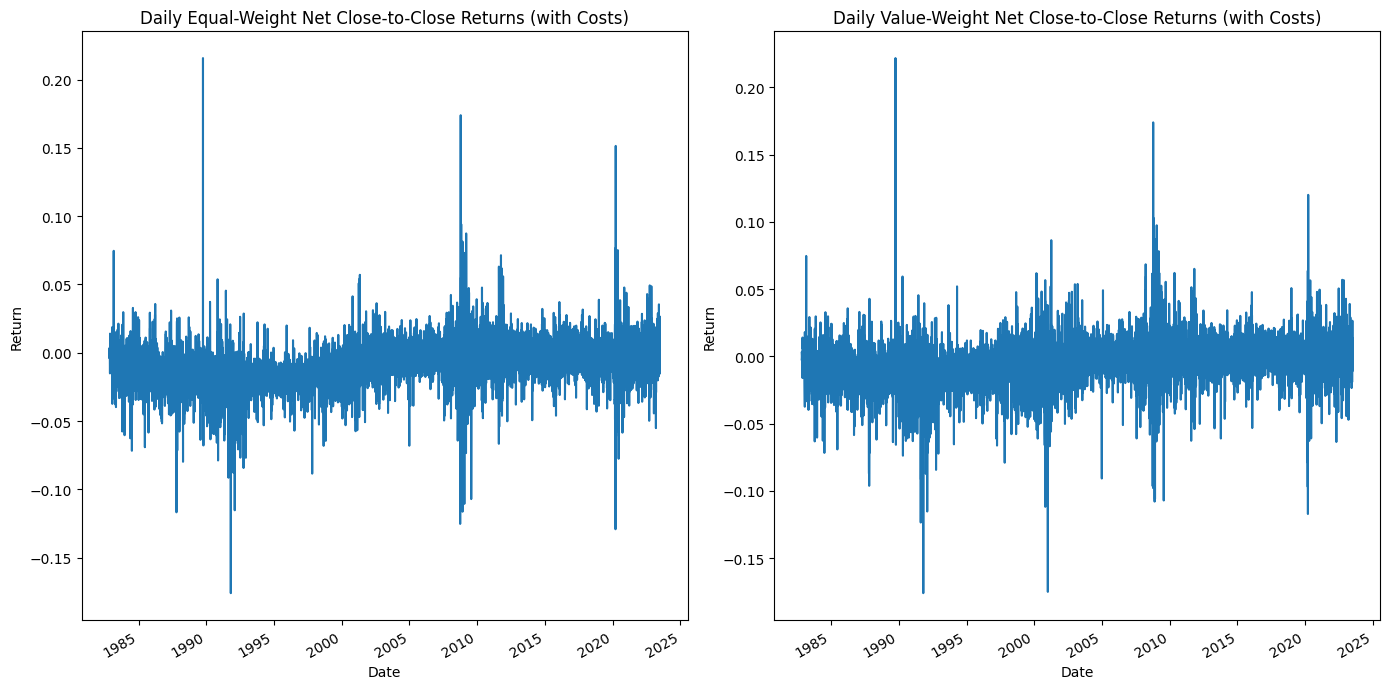

In [ ]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
daily5['r_eq'].plot()
plt.title('Daily Equal-Weight Net Close-to-Close Returns (with Costs)')
plt.xlabel('Date')
plt.ylabel('Return')

plt.subplot(1, 2, 2)
daily5_vw.plot()
plt.title('Daily Value-Weight Net Close-to-Close Returns (with Costs)')
plt.xlabel('Date')
plt.ylabel('Return')

plt.tight_layout()
plt.show()

Observe the trends in the plots:

*   **Overall Negative Trend:** Both the equal-weight and value-weight portfolios exhibit a clear downward trend over time. This visually supports the negative annualized returns calculated in the net returns analysis.
*   **Volatility:** The daily returns are quite volatile, fluctuating significantly around the negative mean.
*   **Impact of Value-Weighting:** The value-weighted portfolio appears slightly less volatile than the equal-weight portfolio, although both show substantial daily swings. This aligns with the slightly better (less negative) annualized return and Sharpe ratio for the value-weighted portfolio compared to the equal-weight portfolio in the net returns analysis, suggesting that transaction costs have a larger impact on smaller, less liquid stocks that receive higher weight in the equal-weight portfolio.
*   **No Clear Periods of Sustained Positive Performance:** The plots do not show any extended periods where the strategy consistently generated positive net returns. There are occasional positive spikes, but these are infrequent and do not offset the overall negative performance.

# **7. Summary**

## Data Analysis Key Findings

*   The initial dataset of dividend events contained over 1.4 million rows, which were reduced to approximately 630,000 tradable events after applying filters for dividend amount (\$\geq\$0.01), market capitalization (\$\geq\$50M), common shares, and duplicate resolution.
*   The date range of the filtered dividend event data spans from 1986-01-02 to 2023-12-29, with over 83,000 unique event days.
*   The IRX (3-month Treasury bill yield) and Fama-French daily factor data were successfully loaded and prepared, covering periods relevant to the dividend event data.
*   The distribution of the price drop relative to the dividend amount (`drop_over_div`) is heavily concentrated around zero, with a robust 1%-99% range of approximately [-3.5, 4.2].
*   An equal-weight portfolio of tradable ex-dividend events yielded an annualized return of approximately -1.1% and a Sharpe ratio of -0.14 based on close-to-close returns.
*   A value-weight portfolio of tradable ex-dividend events yielded an annualized return of approximately -0.2% and a Sharpe ratio of -0.03 based on close-to-close returns.
*   Analysis by dividend yield (D/P) deciles shows a general trend of increasing annualized return and Sharpe ratio from lower to higher deciles, although the relationship is not perfectly monotonic. The highest decile (Decile 10) exhibits the highest annualized return and Sharpe ratio.
